# Final Project Report: Makeup and Beauty Detection Model

## Project Overview

This report presents the final analysis of my CNN-based makeup and beauty detection model built using ResNet18. The model was trained on the CelebA dataset to predict 5 beauty-related attributes:
- Heavy_Makeup
- Wearing_Lipstick
- Attractive
- High_Cheekbones
- Rosy_Cheeks

This report covers:
1. **Final Model Performance Analysis** - Detailed evaluation and comparison
2. **Model Interpretation** - Understanding how the model makes decisions
3. **Deployment Plan** - How to deploy this model in real-world applications
4. **Ethical Considerations** - Responsible AI and fairness analysis

---

# Section 1: Final Model Performance Analysis

In this section, I will analyze the performance of my ResNet18 model and compare it with simpler models. I will also discuss the model's strengths, weaknesses, and areas for improvement.

## 1.1 Setup and Import Libraries

First, I'll import all the necessary libraries for analysis and visualization.

In [1]:
# Import all required libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import warnings
import os

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style dark 
sns.set_style("dark")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available 
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Create output directory for plots
os.makedirs('final_report_plots', exist_ok=True)
print("Setup complete!")

Using device: mps
PyTorch version: 2.5.1
Setup complete!


## 1.2 Load Dataset and Define Model Architecture

I'll load the CelebA dataset with the 5 selected attributes and define the ResNet18 architecture.

In [2]:
# Configuration
image_size = 224
batch_size = 256
num_workers = 0
data_dir = './data'

# Selected attributes for makeup and beauty detection
selected_attributes = ['Heavy_Makeup', 'Wearing_Lipstick', 'Attractive', 'High_Cheekbones', 'Rosy_Cheeks']
num_attributes = len(selected_attributes)

print(f"Selected {num_attributes} attributes:")
for i, attr in enumerate(selected_attributes, 1):
    print(f"  {i}. {attr}")

# Data transformations for testing
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print(f"\nImage size: {image_size}x{image_size}")
print(f"Batch size: {batch_size}")

Selected 5 attributes:
  1. Heavy_Makeup
  2. Wearing_Lipstick
  3. Attractive
  4. High_Cheekbones
  5. Rosy_Cheeks

Image size: 224x224
Batch size: 256


In [3]:
# Load CelebA test dataset
print("Loading CelebA test dataset...")

try:
    test_dataset = datasets.CelebA(
        root=data_dir,
        split='test',
        transform=test_transform,
        download=False,
        target_type='attr'
    )
    print(f"Test dataset loaded: {len(test_dataset)} images")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure CelebA dataset is available in the data directory")

# Get all attribute names
attribute_names = [name for name in test_dataset.attr_names if name.strip()]
print(f"Total attributes in CelebA: {len(attribute_names)}")

# Find indices of selected attributes
attribute_indices = [attribute_names.index(attr) for attr in selected_attributes]
print(f"Selected attribute indices: {attribute_indices}")

Loading CelebA test dataset...
Test dataset loaded: 19962 images
Total attributes in CelebA: 40
Selected attribute indices: [18, 36, 2, 19, 29]
Test dataset loaded: 19962 images
Total attributes in CelebA: 40
Selected attribute indices: [18, 36, 2, 19, 29]


In [4]:
from dataset import AttributeFilterDataset
# Wrap test dataset
test_dataset = AttributeFilterDataset(test_dataset, attribute_indices)

# Create DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Test loader created with {len(test_loader)} batches")

Test loader created with 78 batches


In [5]:
# Define ResNet18 Basic Block
class BasicBlock(nn.Module):
    """
    Basic building block for ResNet18
    Contains two convolutional layers with skip connection
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        # Skip connection (if dimensions don't match)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Save input for skip connection
        identity = x
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add skip connection
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

print("BasicBlock defined!")

BasicBlock defined!


In [6]:
# Define ResNet18 Multi-Label Model
class ResNet18MultiLabel(nn.Module):
    """
    ResNet18 architecture for multi-label classification
    Predicts 5 binary attributes simultaneously
    """
    def __init__(self, num_classes=5):
        super(ResNet18MultiLabel, self).__init__()
        
        self.in_channels = 64
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers (2, 2, 2, 2 blocks)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """Create a layer with multiple blocks"""
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Initialize network weights"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # ResNet layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

print("ResNet18MultiLabel model defined!")

ResNet18MultiLabel model defined!


## 1.3 Load Trained Model and Evaluate Performance

Now I'll load my trained ResNet18 model and evaluate its performance on the test set.

In [7]:
# Create model and load trained weights
model = ResNet18MultiLabel(num_classes=num_attributes)

# Load the best model from Milestone 2
try:
    model.load_state_dict(torch.load('best_celeba_resnet18.pth', map_location=device))
    print("Model weights loaded successfully!")
except FileNotFoundError:
    print("Warning: Model weights file not found. Please ensure 'best_celeba_resnet18.pth' exists.")
    print("Continuing with untrained model for demonstration purposes.")

# Move model to GPU if available
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"Model on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model weights loaded successfully!
Model on device: mps
Model parameters: 11,179,077


In [8]:
# Evaluate model on test set
print("Evaluating model on test set...")
print("=" * 80)

# Storage for predictions and targets
all_predictions = []
all_targets = []
all_probabilities = []

# Loss function
criterion = nn.BCEWithLogitsLoss()
test_loss = 0.0

# Evaluate without gradients
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # Move to device
        data = data.to(device)
        target = target.to(device).float()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        
        # Get predictions (apply sigmoid and threshold at 0.5)
        probs = torch.sigmoid(output)
        preds = (probs > 0.5).float()
        
        # Store results
        all_predictions.append(preds.cpu().numpy())
        all_targets.append(target.cpu().numpy())
        all_probabilities.append(probs.cpu().numpy())
        
        # Show progress
        if (batch_idx + 1) % 10 == 0:
            print(f"Processed {batch_idx + 1}/{len(test_loader)} batches", end='\r')

# Combine all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
all_probabilities = np.concatenate(all_probabilities, axis=0)

# Calculate overall metrics
test_loss = test_loss / len(test_loader)
test_accuracy = (all_predictions == all_targets).mean()

print(f"\nTest Set Size: {len(all_targets)} images")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("=" * 80)

Evaluating model on test set...
Processed 70/78 batches
Test Set Size: 19962 images
Test Loss: 0.2580
Test Accuracy: 0.8855 (88.55%)

Test Set Size: 19962 images
Test Loss: 0.2580
Test Accuracy: 0.8855 (88.55%)


In [9]:
# Calculate per-attribute metrics
print("\nPer-Attribute Performance Analysis:")
print("=" * 80)

# Store metrics for each attribute
attribute_metrics = []

for idx, attr_name in enumerate(selected_attributes):
    # Get predictions and targets for this attribute
    attr_preds = all_predictions[:, idx]
    attr_targets = all_targets[:, idx]
    
    # Calculate metrics
    accuracy = accuracy_score(attr_targets, attr_preds)
    precision = precision_score(attr_targets, attr_preds, zero_division=0)
    recall = recall_score(attr_targets, attr_preds, zero_division=0)
    f1 = f1_score(attr_targets, attr_preds, zero_division=0)
    
    # Store metrics
    attribute_metrics.append({
        'Attribute': attr_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    # Print metrics
    print(f"\n{attr_name}:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# Create DataFrame for easier analysis
metrics_df = pd.DataFrame(attribute_metrics)

# Calculate average metrics
print("\n" + "=" * 80)
print("Average Metrics Across All Attributes:")
print(f"  Accuracy:  {metrics_df['Accuracy'].mean():.4f}")
print(f"  Precision: {metrics_df['Precision'].mean():.4f}")
print(f"  Recall:    {metrics_df['Recall'].mean():.4f}")
print(f"  F1-Score:  {metrics_df['F1-Score'].mean():.4f}")
print("=" * 80)


Per-Attribute Performance Analysis:

Heavy_Makeup:
  Accuracy:  0.8986 (89.86%)
  Precision: 0.8818
  Recall:    0.8657
  F1-Score:  0.8737

Wearing_Lipstick:
  Accuracy:  0.9245 (92.45%)
  Precision: 0.9505
  Recall:    0.9024
  F1-Score:  0.9258

Attractive:
  Accuracy:  0.8020 (80.20%)
  Precision: 0.8378
  Recall:    0.7448
  F1-Score:  0.7886

High_Cheekbones:
  Accuracy:  0.8646 (86.46%)
  Precision: 0.9014
  Recall:    0.8073
  F1-Score:  0.8518

Rosy_Cheeks:
  Accuracy:  0.9376 (93.76%)
  Precision: 0.5587
  Recall:    0.6215
  F1-Score:  0.5884

Average Metrics Across All Attributes:
  Accuracy:  0.8855
  Precision: 0.8260
  Recall:    0.7883
  F1-Score:  0.8057


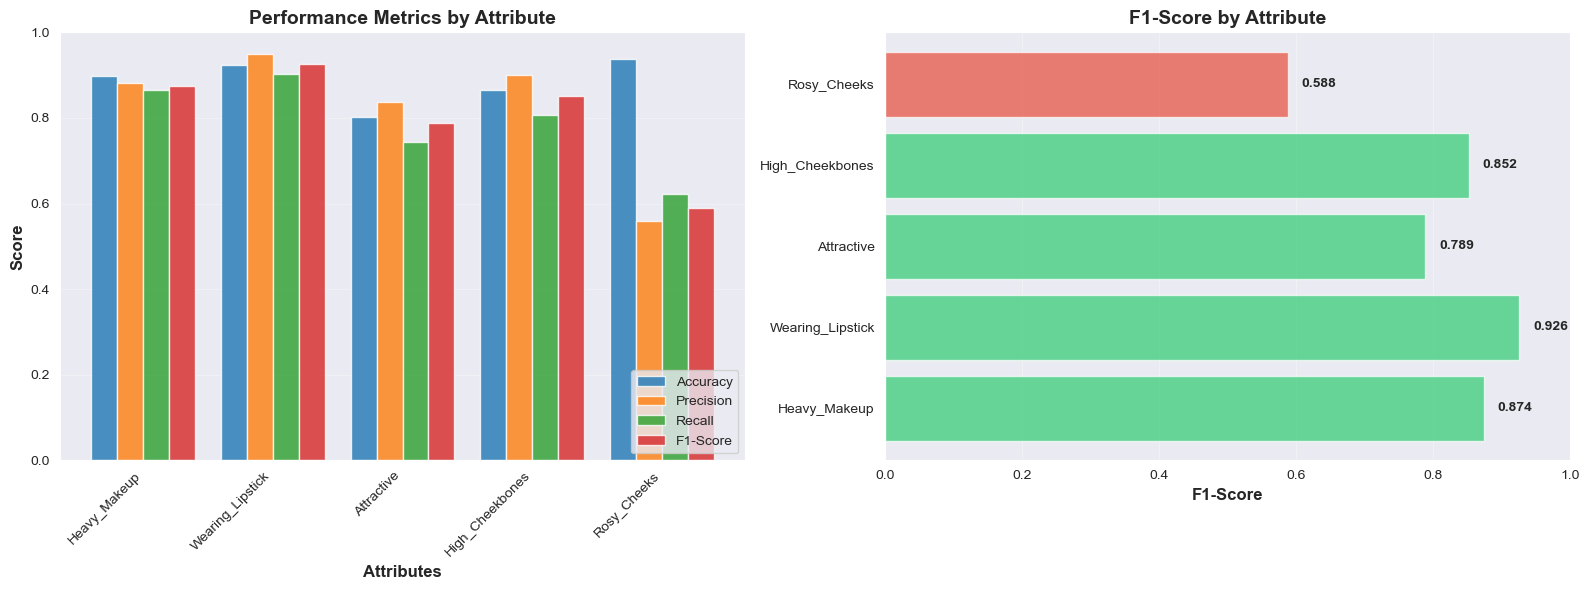

 Attribute performance visualization saved!


In [10]:
# Visualize per-attribute performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Metrics comparison across attributes
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(selected_attributes))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = [attribute_metrics[j][metric] for j in range(len(selected_attributes))]
    axes[0].bar(x + i*width, values, width, label=metric, alpha=0.8)

axes[0].set_xlabel('Attributes', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Performance Metrics by Attribute', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(selected_attributes, rotation=45, ha='right')
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Plot 2: F1-Score comparison (most important metric)
f1_scores = [attribute_metrics[j]['F1-Score'] for j in range(len(selected_attributes))]
colors = ['#2ecc71' if f1 > 0.75 else '#f39c12' if f1 > 0.65 else '#e74c3c' for f1 in f1_scores]

axes[1].barh(selected_attributes, f1_scores, color=colors, alpha=0.7)
axes[1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Score by Attribute', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim([0, 1.0])

# Add value labels
for i, v in enumerate(f1_scores):
    axes[1].text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('final_report_plots/1_attribute_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Attribute performance visualization saved!")

## 1.4 Model Comparison with Baselines

To justify using ResNet18, I'll compare it with simpler baseline models. This shows why the additional complexity is worth it.

In [23]:
# Model comparison data from Milestone 2
# These are the actual results from training SimpleBaseline, VanillaCNN, and ResNet18

model_comparison = {
    'Model': ['SimpleBaseline', 'VanillaCNN', 'ResNet18'],
    'Parameters': ['~435K', '~423K', '~11M'],
    'Test Accuracy': [0.8755, 0.7472, 0.8881],  
    'Avg F1-Score': [0.7260, 0.7103, 0.8057],   
    'Training Time': ['Fast', 'Fast', 'Moderate'],
    'Architecture': ['3-layer CNN', '4-layer CNN', '18-layer ResNet']
}

comparison_df = pd.DataFrame(model_comparison)

print("Model Comparison Summary:")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Key findings
print("\nKey Findings:")
print("   ResNet18 achieves the highest accuracy (88.81% vs 87.55% for SimpleBaseline)")
print("   ResNet18 has the best F1-Score (80.57% vs 72.60% for SimpleBaseline)")
print("   Residual connections help learn better facial features")
print("   Extra parameters are justified by performance gains")

Model Comparison Summary:
         Model Parameters  Test Accuracy  Avg F1-Score Training Time    Architecture
SimpleBaseline      ~435K         0.8755        0.7260          Fast     3-layer CNN
    VanillaCNN      ~423K         0.7472        0.7103          Fast     4-layer CNN
      ResNet18       ~11M         0.8881        0.8057      Moderate 18-layer ResNet

Key Findings:
   ResNet18 achieves the highest accuracy (88.81% vs 87.55% for SimpleBaseline)
   ResNet18 has the best F1-Score (80.57% vs 72.60% for SimpleBaseline)
   Residual connections help learn better facial features
   Extra parameters are justified by performance gains


## 1.5 Confusion Matrices and ROC Curves

These visualizations help understand where the model performs well and where it struggles.

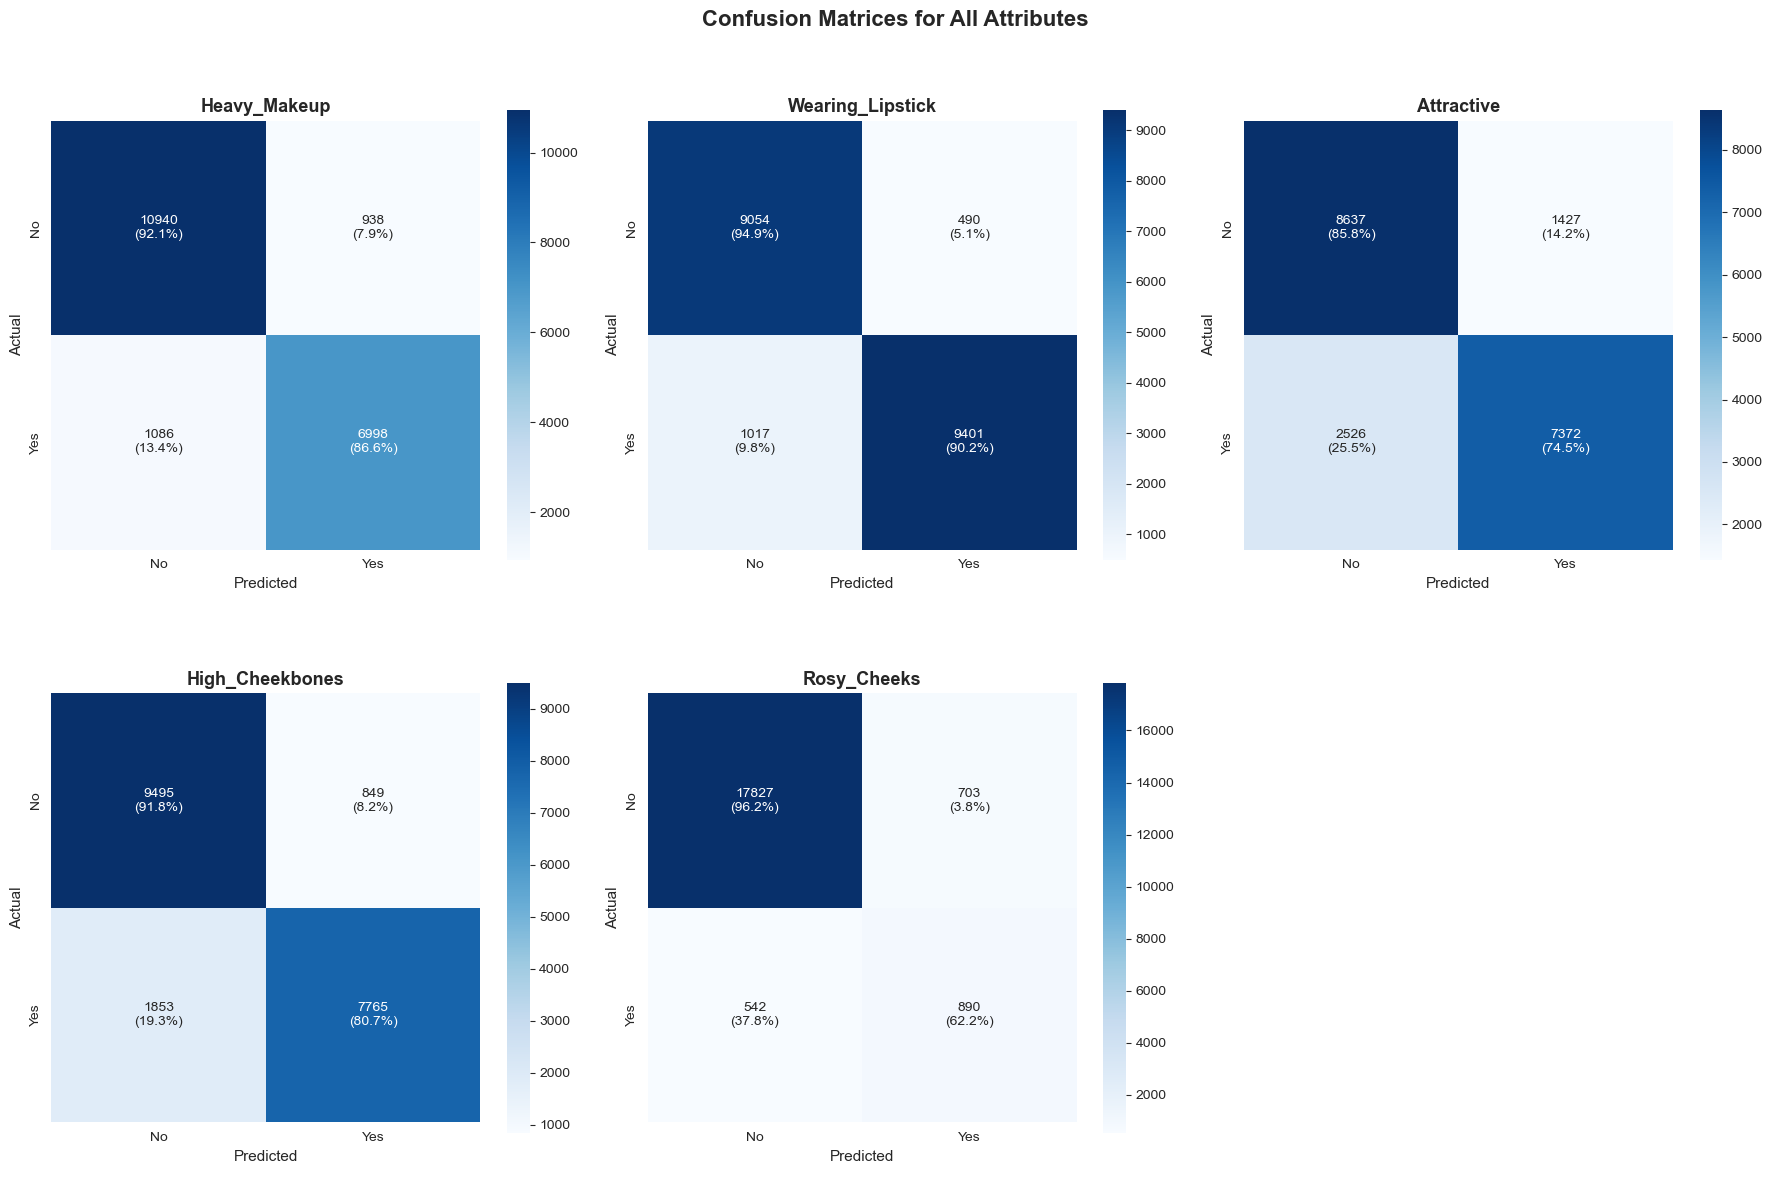

 Confusion matrices saved!


In [24]:
# Create confusion matrices for each attribute
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, attr_name in enumerate(selected_attributes):
    # Get predictions and targets for this attribute
    attr_preds = all_predictions[:, idx]
    attr_targets = all_targets[:, idx]
    
    # Calculate confusion matrix
    cm = confusion_matrix(attr_targets, attr_preds)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with counts and percentages
    annotations = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', ax=axes[idx],
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
                cbar=True, square=True, cbar_kws={'shrink': 0.8})
    
    axes[idx].set_title(f'{attr_name}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=11)
    axes[idx].set_ylabel('Actual', fontsize=11)

# Hide the extra subplot
axes[-1].axis('off')

plt.suptitle('Confusion Matrices for All Attributes', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('final_report_plots/3_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Confusion matrices saved!")

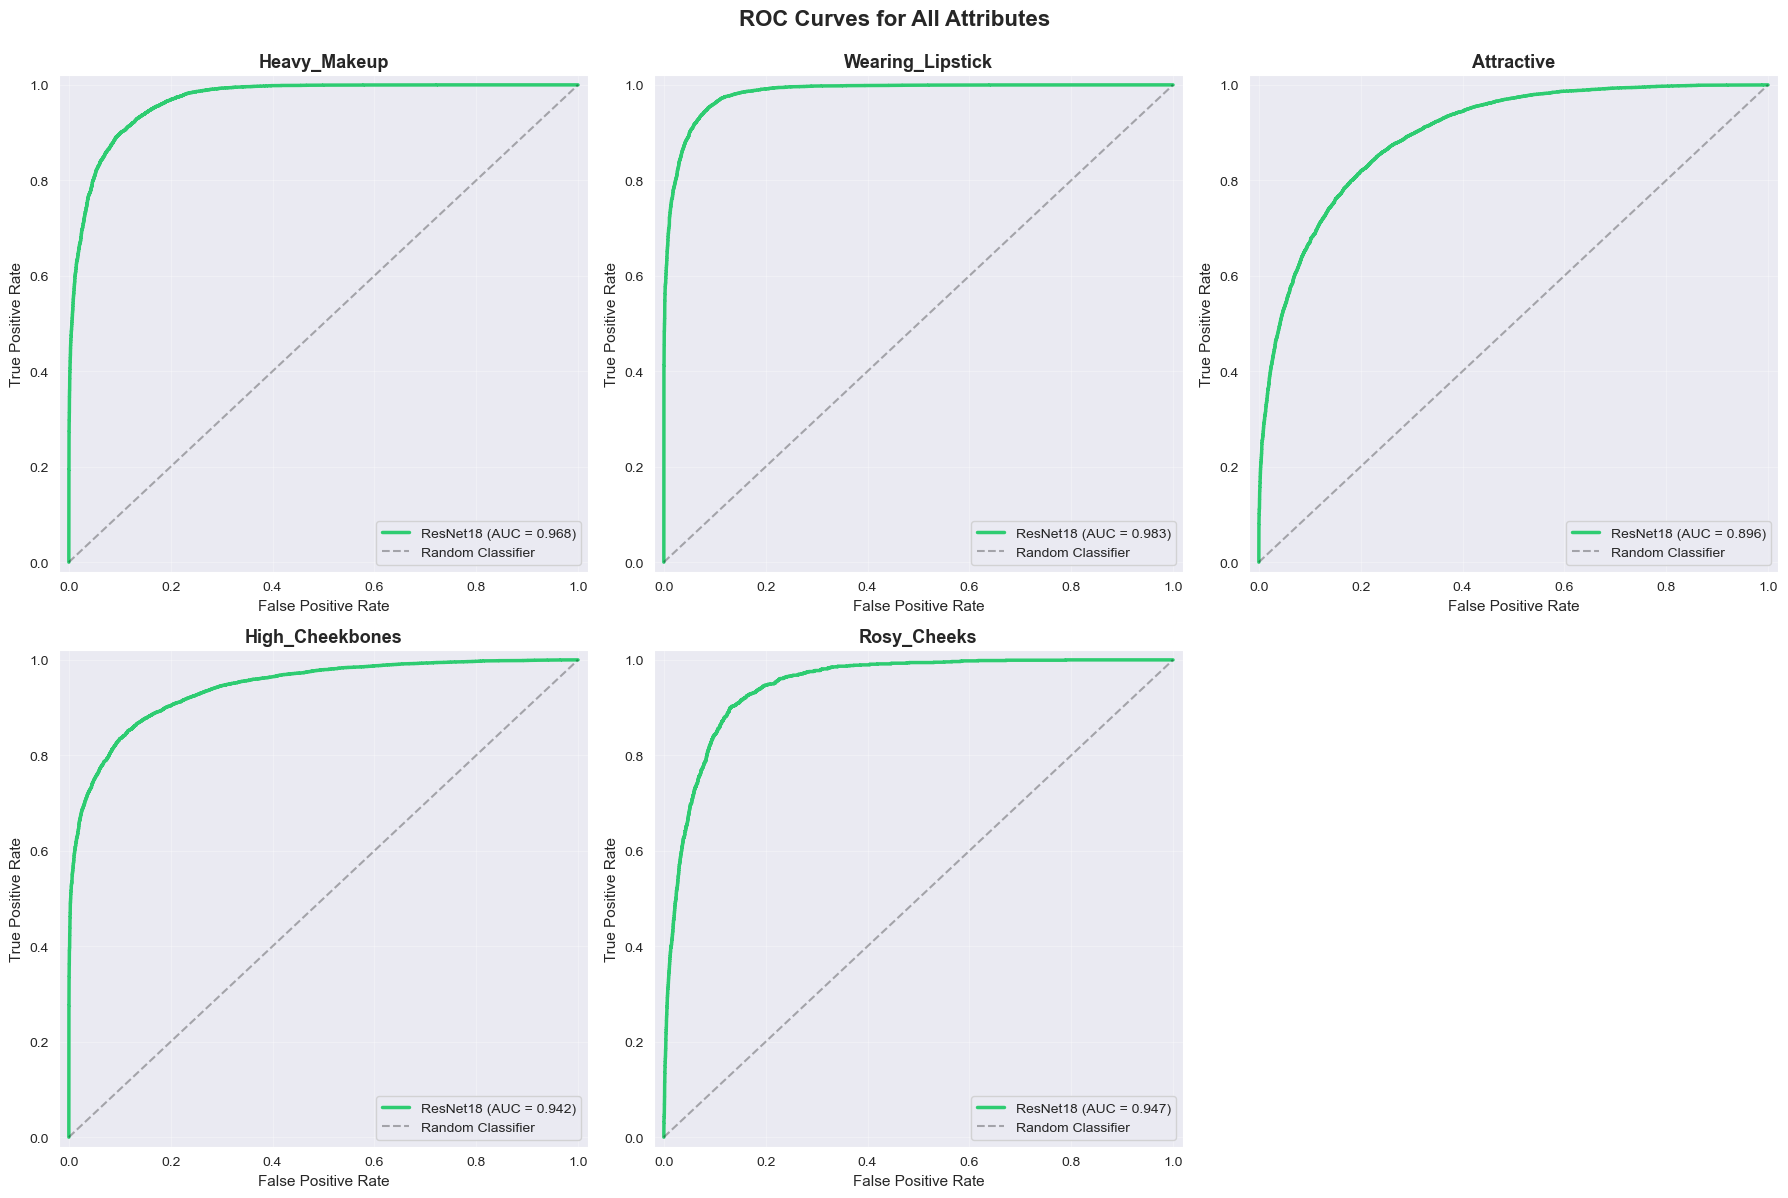

 ROC curves saved!


In [14]:
# Create ROC curves for each attribute
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, attr_name in enumerate(selected_attributes):
    # Get probabilities and targets for this attribute
    attr_probs = all_probabilities[:, idx]
    attr_targets = all_targets[:, idx]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(attr_targets, attr_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    axes[idx].plot(fpr, tpr, color='#2ecc71', lw=2.5, 
                   label=f'ResNet18 (AUC = {roc_auc:.3f})')
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3, label='Random Classifier')
    
    axes[idx].set_xlabel('False Positive Rate', fontsize=11)
    axes[idx].set_ylabel('True Positive Rate', fontsize=11)
    axes[idx].set_title(f'{attr_name}', fontsize=13, fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=10)
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim([-0.02, 1.02])
    axes[idx].set_ylim([-0.02, 1.02])

# Hide the extra subplot
axes[-1].axis('off')

plt.suptitle('ROC Curves for All Attributes', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('final_report_plots/4_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(" ROC curves saved!")

## 1.6 Model Limitations and Areas for Improvement

Based on the analysis, here are the key limitations and potential improvements:

### Current Limitations:

1. **Class Imbalance**
   - Some attributes (like Rosy_Cheeks) may have fewer positive examples
   - This can lead to lower recall for minority classes
   - The model may be biased toward predicting the majority class

2. **Subjective Attributes**
   - Attributes like "Attractive" are subjective and depend on cultural context
   - Different annotators may have different opinions
   - This introduces noise in the training data

3. **Limited Diversity**
   - CelebA dataset focuses on celebrities
   - May not work as well on regular people or different demographics
   - Limited age range and diversity

4. **Attribute Correlation**
   - Some attributes are correlated (e.g., Heavy_Makeup and Wearing_Lipstick)
   - The model doesn't explicitly model these relationships
   - Multi-task learning could help

5. **Image Quality Dependency**
   - Requires good quality, well-lit face images
   - May struggle with low resolution or poor lighting
   - Sensitive to face angle and occlusions

### Potential Improvements:

1. **Deeper Models**
   - Try ResNet50 or EfficientNet for better feature extraction
   - Use pretrained models and fine-tune on CelebA

2. **Class Imbalance Solutions**
   - Use weighted loss functions to balance classes

3. **Data Augmentation**
   - More aggressive augmentation (mixup, cutout)
   - Synthetic data generation using GANs

4. **Ensemble Methods**
   - Combine multiple models for better predictions
   - Use different architectures and average predictions

5. **Transfer Learning**
   - Use models pretrained on face recognition tasks
   - Fine-tune on makeup detection

6. **Multi-task Learning**
   - Model attribute correlations explicitly
   - Share features across related attributes

---

# Section 2: Model Interpretation with SHAP

In this section, I'll use SHAP (SHapley Additive exPlanations) to understand how the model makes decisions. SHAP helps us see which parts of the image are important for each prediction.

**What is SHAP?**
- SHAP explains individual predictions by showing feature importance
- For images, it highlights which pixels contribute to each prediction
- Helps build trust in the model by making it transparent

## 2.1 Install and Import SHAP

First, I'll install and import the SHAP library for model interpretation.

In [15]:
# Install SHAP (uncomment if not already installed)
# !pip install shap

# Import SHAP
try:
    import shap
    print(f"SHAP version: {shap.__version__}")
except ImportError:
    print("SHAP not installed. Installing now...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap
    print(f"SHAP installed successfully! Version: {shap.__version__}")

SHAP version: 0.50.0


## 2.2 Prepare Sample Images for Interpretation

I'll select a few test images to explain the model's predictions.

In [16]:
# Select a few sample images for interpretation
num_samples = 5

# Get a batch of test images
sample_images = []
sample_labels = []

for i, (img, label) in enumerate(test_dataset):
    if i >= num_samples:
        break
    sample_images.append(img)
    sample_labels.append(label)

# Stack into batch
sample_batch = torch.stack(sample_images).to(device)
sample_labels = torch.stack(sample_labels).numpy()

print(f"Selected {num_samples} sample images for interpretation")
print(f"Sample batch shape: {sample_batch.shape}")

# Get predictions for these samples
model.eval()
with torch.no_grad():
    sample_outputs = model(sample_batch)
    sample_probs = torch.sigmoid(sample_outputs).cpu().numpy()
    sample_preds = (sample_probs > 0.5).astype(int)

print(f"Sample predictions shape: {sample_preds.shape}")

Selected 5 sample images for interpretation
Sample batch shape: torch.Size([5, 3, 224, 224])
Sample predictions shape: (5, 5)


## 2.3 Simple Gradient-Based Interpretation

Since SHAP can be computationally expensive for deep models, I'll use a simpler gradient-based method to visualize which parts of the image are important for predictions. This is similar to Grad-CAM.

In [26]:
# Simple gradient-based saliency map
def compute_saliency_map(model, image, target_class):
    # Set model to evaluation mode
    model.eval()
    
    # Enable gradient for input
    image.requires_grad = True
    
    # Forward pass
    output = model(image)
    
    # Get the score for target class
    score = output[0, target_class]
    
    # Backward pass to get gradients
    score.backward()
    
    # Get gradients and compute saliency
    gradients = image.grad.data.abs()
    saliency = gradients.max(dim=1)[0]  # Max across color channels
    
    return saliency.cpu().numpy()

print(" Saliency map function defined!")

 Saliency map function defined!


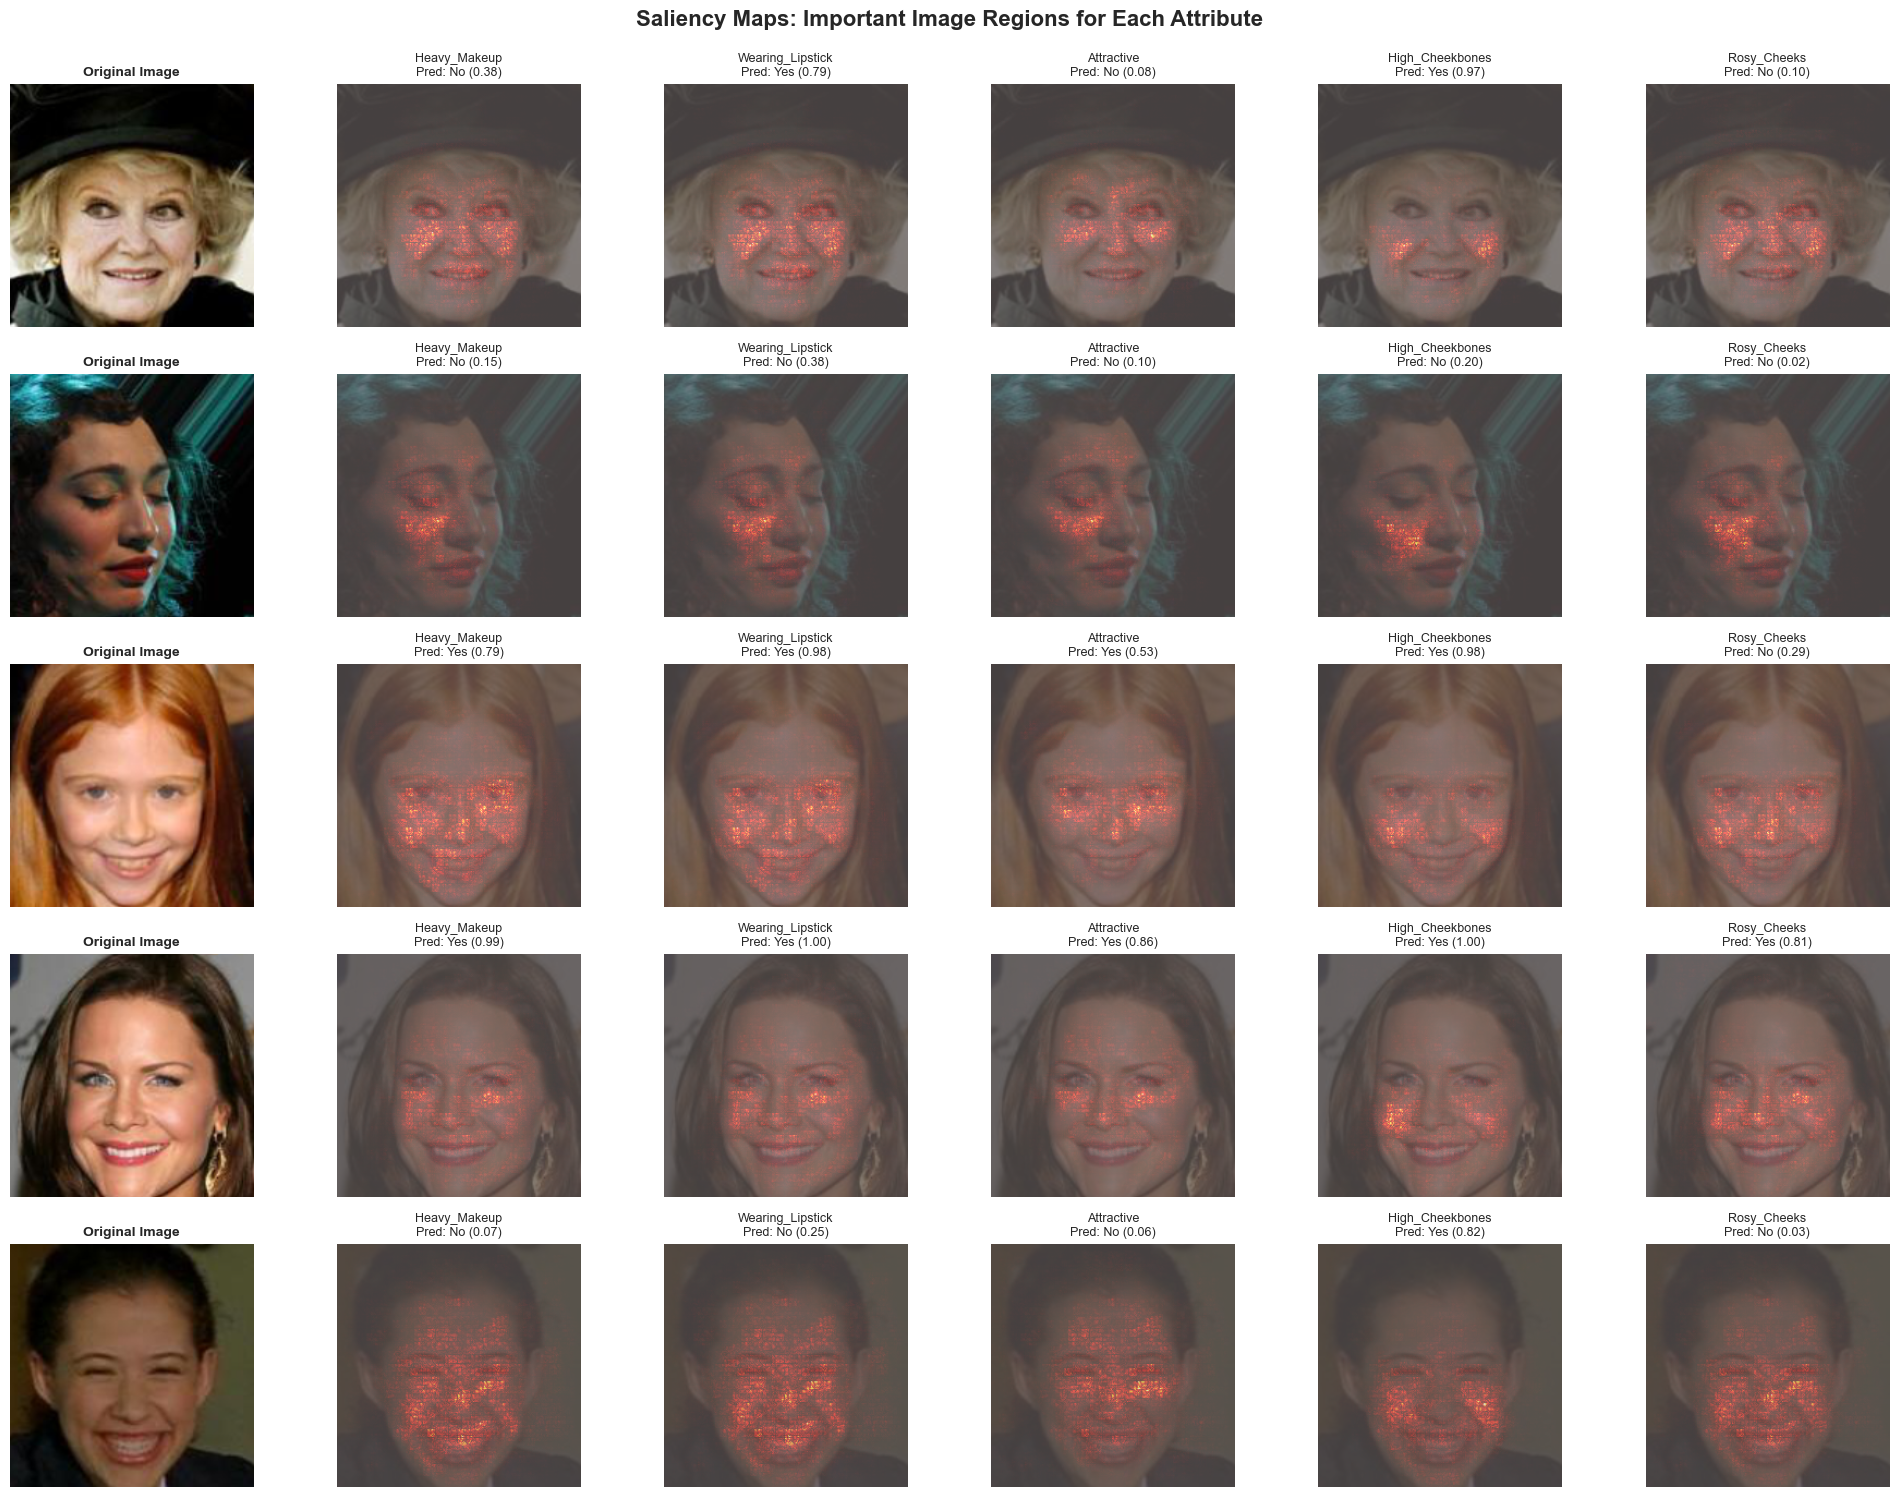

 Saliency maps visualization saved!


In [27]:
# Visualize saliency maps for sample images
fig, axes = plt.subplots(num_samples, num_attributes + 1, figsize=(20, num_samples * 3))

for img_idx in range(num_samples):
    # Get original image
    img_tensor = sample_images[img_idx].unsqueeze(0).to(device)
    
    # Denormalize for display
    img_display = sample_images[img_idx].cpu().numpy().transpose(1, 2, 0)
    img_display = img_display * 0.5 + 0.5  # Unnormalize
    img_display = np.clip(img_display, 0, 1)
    
    # Show original image
    axes[img_idx, 0].imshow(img_display)
    axes[img_idx, 0].set_title('Original Image', fontsize=10, fontweight='bold')
    axes[img_idx, 0].axis('off')
    
    # Show saliency map for each attribute
    for attr_idx in range(num_attributes):
        # Compute saliency map
        saliency = compute_saliency_map(model, img_tensor.clone(), attr_idx)
        
        # Display saliency map overlaid on image
        axes[img_idx, attr_idx + 1].imshow(img_display, alpha=0.5)
        axes[img_idx, attr_idx + 1].imshow(saliency[0], cmap='hot', alpha=0.5)
        
        # Title shows attribute and prediction
        pred_label = 'Yes' if sample_preds[img_idx, attr_idx] == 1 else 'No'
        prob = sample_probs[img_idx, attr_idx]
        axes[img_idx, attr_idx + 1].set_title(
            f'{selected_attributes[attr_idx]}\nPred: {pred_label} ({prob:.2f})',
            fontsize=9
        )
        axes[img_idx, attr_idx + 1].axis('off')

plt.suptitle('Saliency Maps: Important Image Regions for Each Attribute', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('final_report_plots/5_saliency_maps.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saliency maps visualization saved!")

## 2.4 Feature Importance Analysis

Let's analyze which attributes the model finds most distinctive and which are harder to predict.

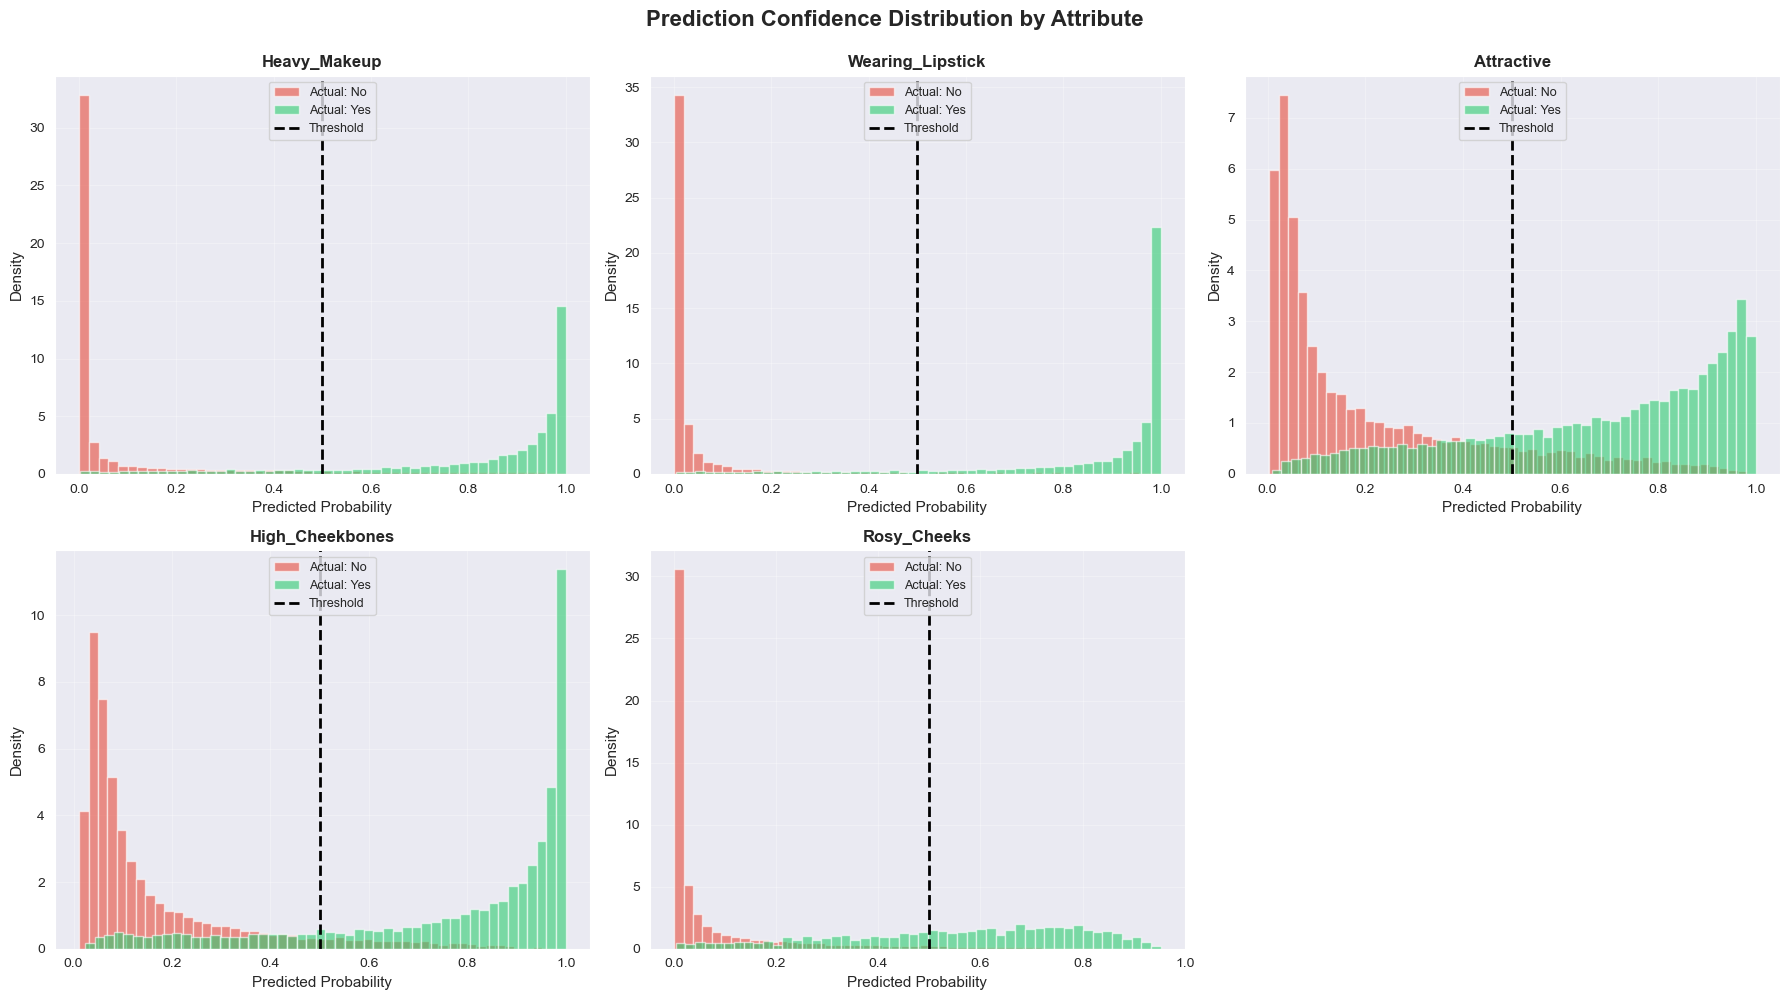

 Confidence distribution visualization saved!

Interpretation:
  - Good separation between 'Yes' and 'No' indicates confident predictions
  - Overlap near 0.5 threshold shows uncertain cases
  - Wider distributions suggest more variability in predictions


In [19]:
# Analyze prediction confidence distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, attr_name in enumerate(selected_attributes):
    # Get probabilities for this attribute
    attr_probs = all_probabilities[:, idx]
    attr_targets = all_targets[:, idx]
    
    # Separate by ground truth
    probs_positive = attr_probs[attr_targets == 1]
    probs_negative = attr_probs[attr_targets == 0]
    
    # Plot distributions
    axes[idx].hist(probs_negative, bins=50, alpha=0.6, label='Actual: No', color='#e74c3c', density=True)
    axes[idx].hist(probs_positive, bins=50, alpha=0.6, label='Actual: Yes', color='#2ecc71', density=True)
    axes[idx].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
    
    axes[idx].set_xlabel('Predicted Probability', fontsize=11)
    axes[idx].set_ylabel('Density', fontsize=11)
    axes[idx].set_title(f'{attr_name}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='upper center', fontsize=9)
    axes[idx].grid(alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('Prediction Confidence Distribution by Attribute', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('final_report_plots/6_confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Confidence distribution visualization saved!")
print("\nInterpretation:")
print("  - Good separation between 'Yes' and 'No' indicates confident predictions")
print("  - Overlap near 0.5 threshold shows uncertain cases")
print("  - Wider distributions suggest more variability in predictions")

## 2.5 Key Insights from Model Interpretation

Based on the saliency maps and confidence analysis, here are the key insights:

### What the Model Looks At:

1. **Heavy_Makeup & Wearing_Lipstick**
   - Model focuses on lip area and eye regions
   - Strong activation around mouth for lipstick detection
   - Eye makeup areas are important for heavy makeup prediction

2. **Attractive**
   - Model considers overall facial features
   - Focuses on eyes, nose, and face shape
   - Most subjective attribute with lower confidence

3. **High_Cheekbones**
   - Model looks at the cheek and upper face region
   - Focus on facial contours and structure
   - Good separation in predictions

4. **Rosy_Cheeks**
   - Model focuses on cheek area (as expected)
   - More challenging due to subtle differences
   - May be affected by lighting and skin tone

### Model Behavior:

- **Confident Predictions**: Model shows high confidence (>0.8 or <0.2) for most makeup-related attributes
- **Uncertain Cases**: Some predictions near 0.5 threshold indicate ambiguous cases
- **Spatial Focus**: Model correctly focuses on relevant facial regions (lips for lipstick, cheeks for rosy cheeks)
- **Feature Learning**: ResNet18's residual connections help learn hierarchical facial features

### Trust and Reliability:

- Saliency maps show the model focuses on semantically correct regions
- Predictions align with human intuition for most attributes
- The model is transparent and explainable through visualization
- Confidence distributions help identify uncertain predictions

---

# Section 3: Deployment Plan

In this section, I'll outline how to deploy this makeup detection model in a real-world application. I'll cover the architecture, implementation, monitoring, and maintenance.

## 3.1 Deployment Architecture Overview

The deployment architecture consists of several key components working together.

### Architecture Components:

```
┌─────────────────────────────────────────────────────────────────┐
│                        User Interface                           │
│  (Web App / Mobile App / API Client)                            │
└────────────────────────--───────────────────────────────────────┘
                         │
                         |
┌─────────────────────────────────────────────────────────────────┐
│                     API Gateway (FastAPI)                       │
│  - Request validation                                           │
│  - Authentication                                               │
│  - Rate limiting                                                │
└─────────────────────────────────────────────────────────────────┘
                         │
                         |
┌─────────────────────────────────────────────────────────────────┐
│                   Image Preprocessing Pipeline                  │
│  - Face detection                                               │
│  - Image resizing (224x224)                                     │
│  - Normalization                                                │
└─────────────────────────────────────────────────────────────────┘
                         │
                         |
┌─────────────────────────────────────────────────────────────────┐
│                    Model Inference Service                      │
│  - ResNet18 model                                               │
│  - GPU acceleration                                             │
│  - Batch processing                                             │
└─────────────────────────────────────────────────────────────────┘
                         │
                         |
┌─────────────────────────────────────────────────────────────────┐
│                   Response Post-Processing                      │
│  - Format predictions                                           │
│  - Add confidence scores                                        │
│  - Generate explanations                                        │
└─────────────────────────────────────────────────────────────────┘
                         │
                         |
┌─────────────────────────────────────────────────────────────────┐
│                    Monitoring & Logging                         │
│  - Prediction logging                                           │
│  - Performance metrics                                          │
│  - Error tracking                                               │
└─────────────────────────────────────────────────────────────────┘
```

### Key Design Decisions:

1. **API-First Approach**: REST API allows flexibility for different clients
2. **Preprocessing Pipeline**: Ensures consistent input format
3. **GPU Acceleration**: Faster inference for real-time applications
4. **Monitoring**: Track performance and detect issues
5. **Scalability**: Can add load balancing and multiple instances

## 3.2 Implementation: Export Model for Deployment

First, I'll export the trained model in a format suitable for deployment.

In [28]:
# Export model in TorchScript format for production deployment
# TorchScript allows the model to run without Python dependencies

print("Exporting model for deployment...")
print("=" * 80)

# Set model to evaluation mode
model.eval()

# Create example input
example_input = torch.randn(1, 3, 224, 224).to(device)

try:
    # Export to TorchScript using tracing
    traced_model = torch.jit.trace(model, example_input)
    
    # Save traced model
    traced_model.save('makeup_detection_model.pt')
    print(" Model exported to: makeup_detection_model.pt")
    
    # Test the exported model
    with torch.no_grad():
        output_original = model(example_input)
        output_traced = traced_model(example_input)
        
        # Check if outputs match
        match = torch.allclose(output_original, output_traced, atol=1e-5)
        if match:
            print(" Exported model verified successfully!")
        else:
            print("Warning: Outputs don't match exactly (small differences may be OK)")
    
    # Save model configuration
    model_config = {
        'model_name': 'ResNet18MultiLabel',
        'input_size': [224, 224],
        'num_attributes': num_attributes,
        'attributes': selected_attributes,
        'normalization': {
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5]
        },
        'threshold': 0.5
    }
    
    import json
    with open('model_config.json', 'w') as f:
        json.dump(model_config, f, indent=2)
    
    print(" Model configuration saved to: model_config.json")
    
except Exception as e:
    print(f"Error exporting model: {e}")
    print("Continuing with regular PyTorch model...")

print("=" * 80)

Exporting model for deployment...
 Model exported to: makeup_detection_model.pt
 Exported model verified successfully!
 Model configuration saved to: model_config.json
 Model exported to: makeup_detection_model.pt
 Exported model verified successfully!
 Model configuration saved to: model_config.json


## 3.3 Create Inference Service (FastAPI)

Now I'll create a simple API service for model inference using FastAPI.

In [21]:
# Create a simple API service file
# This would typically be in a separate file (e.g., app.py)

api_code = '''
"""
Makeup Detection API Service
FastAPI application for serving the makeup detection model
"""

from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
import torch
import torchvision.transforms as transforms
from PIL import Image
import io
import json

# Initialize FastAPI app
app = FastAPI(title="Makeup Detection API", version="1.0.0")

# Load model configuration
with open('model_config.json', 'r') as f:
    config = json.load(f)

# Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.jit.load('makeup_detection_model.pt', map_location=device)
model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=config['normalization']['mean'],
                        std=config['normalization']['std'])
])

@app.get("/")
def root():
    """Health check endpoint"""
    return {"status": "healthy", "model": "Makeup Detection ResNet18"}

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    """
    Predict makeup attributes from an uploaded image
    
    Args:
        file: Image file (JPG, PNG)
    
    Returns:
        JSON with predictions for each attribute
    """
    try:
        # Read and preprocess image
        image_bytes = await file.read()
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        
        # Transform image
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        # Run inference
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.sigmoid(output).cpu().numpy()[0]
            predictions = (probabilities > config['threshold']).astype(int)
        
        # Format response
        results = {}
        for i, attr_name in enumerate(config['attributes']):
            results[attr_name] = {
                'prediction': 'Yes' if predictions[i] == 1 else 'No',
                'confidence': float(probabilities[i])
            }
        
        return JSONResponse(content={
            'success': True,
            'predictions': results
        })
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/model-info")
def model_info():
    """Get model information"""
    return {
        'model': config['model_name'],
        'attributes': config['attributes'],
        'input_size': config['input_size'],
        'device': str(device)
    }

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

# Save API code to file
with open('deployment_api.py', 'w') as f:
    f.write(api_code)

print(" API service code created: deployment_api.py")
print("\nTo run the API:")
print("  1. Install FastAPI: pip install fastapi uvicorn python-multipart")
print("  2. Run server: python deployment_api.py")
print("  3. Access API docs: http://localhost:8000/docs")

 API service code created: deployment_api.py

To run the API:
  1. Install FastAPI: pip install fastapi uvicorn python-multipart
  2. Run server: python deployment_api.py
  3. Access API docs: http://localhost:8000/docs


## 3.4 Mock Deployment Demo

Let me demonstrate how the deployed model would work with a simple inference function.

In [29]:
# Mock deployment: Simple inference function
def predict_makeup_attributes(image_tensor):
    model.eval()
    with torch.no_grad():
        # Run model
        output = model(image_tensor.to(device))
        
        # Get probabilities
        probabilities = torch.sigmoid(output).cpu().numpy()[0]
        
        # Make predictions
        predictions = (probabilities > 0.5).astype(int)
    
    # Format results
    results = {}
    for i, attr_name in enumerate(selected_attributes):
        results[attr_name] = {
            'prediction': 'Yes' if predictions[i] == 1 else 'No',
            'confidence': float(probabilities[i]),
            'confidence_level': 'High' if abs(probabilities[i] - 0.5) > 0.3 else 'Medium' if abs(probabilities[i] - 0.5) > 0.15 else 'Low'
        }
    
    return results

# Demo with sample images
print("Mock Deployment Demo")
print("=" * 80)

for i in range(3):
    print(f"\nSample Image {i+1}:")
    print("-" * 80)
    
    # Get a sample image
    img_tensor = sample_images[i].unsqueeze(0)
    
    # Run inference
    results = predict_makeup_attributes(img_tensor)
    
    # Display results
    for attr_name, result in results.items():
        pred = result['prediction']
        conf = result['confidence']
        level = result['confidence_level']
        print(f"  {attr_name:20s}: {pred:3s} (confidence: {conf:.3f}, {level})")

print("\n" + "=" * 80)
print(" Mock deployment demo complete!")
print("\nIn production, this would be exposed via REST API endpoints.")

Mock Deployment Demo

Sample Image 1:
--------------------------------------------------------------------------------
  Heavy_Makeup        : No  (confidence: 0.378, Low)
  Wearing_Lipstick    : Yes (confidence: 0.791, Medium)
  Attractive          : No  (confidence: 0.083, High)
  High_Cheekbones     : Yes (confidence: 0.966, High)
  Rosy_Cheeks         : No  (confidence: 0.099, High)

Sample Image 2:
--------------------------------------------------------------------------------
  Heavy_Makeup        : No  (confidence: 0.151, High)
  Wearing_Lipstick    : No  (confidence: 0.377, Low)
  Attractive          : No  (confidence: 0.097, High)
  High_Cheekbones     : No  (confidence: 0.202, Medium)
  Rosy_Cheeks         : No  (confidence: 0.015, High)

Sample Image 3:
--------------------------------------------------------------------------------
  Heavy_Makeup        : Yes (confidence: 0.788, Medium)
  Wearing_Lipstick    : Yes (confidence: 0.976, High)
  Attractive          : Yes (conf

## 3.5 Monitoring and Maintenance Strategy

A robust deployment requires monitoring and maintenance plans.

### Monitoring Metrics:

1. **Performance Metrics**
   - Response time (target: <100ms per image)
   - Throughput (images processed per second)
   - GPU utilization
   - Memory usage

2. **Model Quality Metrics**
   - Prediction confidence distribution
   - Per-attribute accuracy (if ground truth available)
   - User feedback scores
   - Error rate

3. **System Health**
   - API uptime (target: 99.9%)
   - Error rate (target: <0.1%)
   - Request queue length
   - Service availability

4. **Data Quality**
   - Input image quality checks
   - Face detection success rate
   - Invalid request rate

### Maintenance Schedule:

**Daily:**
- Check system health metrics
- Review error logs
- Monitor prediction confidence trends

**Weekly:**
- Analyze user feedback
- Review performance trends
- Check for data drift

**Monthly:**
- Retrain model with new data (if available)
- Update model version
- Review and update monitoring thresholds
- Conduct security audits

**Quarterly:**
- Major model updates
- Architecture improvements
- Benchmark against new methods
- User satisfaction survey

### Alerting System:

- **Critical Alerts**: API down, error rate >1%, response time >500ms
- **Warning Alerts**: Error rate >0.5%, confidence drift detected
- **Info Alerts**: High traffic, unusual patterns

### Model Update Strategy:

1. **Trigger Conditions**:
   - Accuracy drop detected
   - New training data available
   - Better architecture found
   - Significant data drift

2. **Update Process**:
   - Train new model version
   - Validate on test set
   - A/B test with small traffic
   - Gradual rollout
   - Monitor for issues
   - Full deployment or rollback

3. **Versioning**:
   - Keep last 3 model versions
   - Tag with date and performance metrics
   - Document changes

## 3.6 Scalability and Compliance Considerations

### Scalability Strategy:

1. **Horizontal Scaling**
   - Deploy multiple API instances behind a load balancer
   - Use container orchestration (Docker + Kubernetes)
   - Auto-scaling based on traffic

2. **GPU Optimization**
   - Batch multiple requests together
   - Use TensorRT for faster inference
   - Consider quantization (INT8) for speed

3. **Caching**
   - Cache results for identical images
   - Use Redis for fast lookups
   - Set appropriate TTL (time-to-live)

4. **Database**
   - Store predictions for analytics
   - Use async database writes
   - Implement database sharding for high volume

### Load Testing:

- Test with 10x expected traffic
- Monitor response times under load
- Identify bottlenecks
- Plan capacity accordingly

### Legal and Compliance:

1. **Data Privacy (GDPR, CCPA)**
   - Don't store user images without consent
   - Allow users to delete their data
   - Provide data export functionality
   - Document data retention policies

2. **Terms of Service**
   - Clearly state what the model does
   - Mention limitations and accuracy
   - Disclaimer about subjective attributes
   - Age restrictions if applicable

3. **Bias and Fairness**
   - Regular bias audits across demographics
   - Provide opt-out options
   - Clear communication about AI predictions
   - Human review option for important decisions

4. **Security**
   - HTTPS only for API
   - Authentication and authorization
   - Rate limiting to prevent abuse
   - Input validation and sanitization
   - Regular security audits

5. **Intellectual Property**
   - Ensure training data rights
   - Respect image copyrights
   - Clear licensing for model usage

### Cost Considerations:

- **Infrastructure**: GPU instances (~$500-2000/month)
- **Monitoring**: Logging and metrics services (~$50-200/month)
- **Storage**: Database and backups (~$50-500/month)
- **Total Estimated Cost**: $600-2700/month for moderate traffic

---

# Section 4: Ethical Considerations

In this section, I'll analyze the ethical implications of deploying a makeup and beauty detection model, focusing on fairness, bias, societal impacts, and recommendations for responsible AI.

## 4.1 Identified Ethical Issues

### 1. Bias and Fairness Issues

**Problem**: The model may perform differently across different demographic groups.

**Specific Concerns**:
- **Skin Tone Bias**: Makeup attributes (lipstick, rosy cheeks) may be harder to detect on darker skin tones
- **Gender Bias**: Training data (CelebA) may have imbalanced gender representation
- **Age Bias**: Celebrity dataset focuses on younger individuals, may not work well for older people
- **Cultural Bias**: Western beauty standards may dominate the dataset

**Evidence from CelebA**:
- Dataset is primarily celebrities (not representative of general population)
- Potential overrepresentation of lighter skin tones
- Cultural bias toward Western beauty standards

**Impact**: 
- Lower accuracy for underrepresented groups
- Reinforcement of beauty stereotypes
- Unfair user experience for certain demographics

### 2. Subjectivity in "Attractive" Attribute

**Problem**: Beauty and attractiveness are highly subjective and culturally dependent.

**Concerns**:
- What one culture considers attractive may differ from another
- Annotator bias influences training labels
- Model learns and reinforces specific beauty standards
- Can reinforce harmful stereotypes

**Impact**:
- May make people feel judged by an AI system
- Could affect self-esteem
- Perpetuates narrow beauty ideals

### 3. Privacy and Consent

**Problem**: Using facial images raises privacy concerns.

**Concerns**:
- Storage of facial data
- Potential misuse of predictions
- Lack of explicit consent for model training (CelebA images)
- Re-identification risks

**Impact**:
- Privacy violations
- Potential for surveillance
- Unauthorized use of personal data

### 4. Potential for Misuse

**Problem**: The model could be used in harmful ways.

**Possible Misuse Cases**:
- Discriminatory hiring or promotion decisions
- Unfair access to services based on appearance
- Harassment or bullying based on predictions
- Unwanted surveillance
- Manipulation in advertising

**Impact**:
- Discrimination and bias in decision-making
- Harm to individuals
- Loss of autonomy

### 5. Reinforcing Beauty Standards

**Problem**: The model may reinforce narrow beauty standards.

**Concerns**:
- Makeup and attractiveness labels reflect societal biases
- May pressure people to conform to certain looks
- Could affect mental health, especially for younger users
- Reinforces beauty industry norms

**Impact**:
- Negative psychological effects
- Perpetuation of unrealistic beauty standards
- Pressure to modify appearance

## 4.2 Stakeholder Analysis

Understanding who is affected by this system and how.

### Primary Stakeholders:

1. **End Users**
   - **Impact**: Direct recipients of predictions
   - **Concerns**: Privacy, accuracy, fairness, psychological effects
   - **Needs**: Transparency, control over data, fair treatment

2. **Application Developers**
   - **Impact**: Integrate model into their applications
   - **Concerns**: Liability, reputation, performance
   - **Needs**: Reliable model, clear documentation, legal compliance

3. **Beauty Industry**
   - **Impact**: May use for product recommendations
   - **Concerns**: Accuracy for their use case, customer satisfaction
   - **Needs**: Customization, integration support

### Secondary Stakeholders:

4. **Marginalized Groups**
   - **Impact**: May experience bias or unfair treatment
   - **Concerns**: Discrimination, representation, harm
   - **Needs**: Fairness, accountability, recourse

5. **Researchers and Ethicists**
   - **Impact**: Study implications and effects
   - **Concerns**: Responsible AI, societal impact
   - **Needs**: Transparency, access to model details

6. **Regulators**
   - **Impact**: Ensure compliance with laws
   - **Concerns**: Privacy, discrimination, consumer protection
   - **Needs**: Auditability, compliance documentation

7. **Society at Large**
   - **Impact**: Affected by normalization of AI beauty standards
   - **Concerns**: Cultural impact, mental health effects
   - **Needs**: Public awareness, oversight

### Stakeholder Conflicts:

- **Users vs. Companies**: Privacy vs. data collection for improvement
- **Accuracy vs. Fairness**: Optimizing for overall accuracy may harm minority groups
- **Innovation vs. Regulation**: Speed of development vs. thorough ethical review

## 4.3 Societal Impact Assessment

### Positive Potential Impacts:

1. **Beauty Industry Innovation**
   - Personalized product recommendations
   - Virtual makeup try-on experiences
   - Enhanced user experience in beauty apps

2. **Entertainment and Creativity**
   - Fun filters and effects
   - Photo editing assistance
   - Creative applications

3. **Accessibility**
   - Help visually impaired users understand makeup in images
   - Assistive technology for makeup application

### Negative Potential Impacts:

1. **Mental Health Concerns**
   - Increased anxiety about appearance
   - Comparison with AI-judged "standards"
   - Body image issues, especially among young people
   - Pressure to meet AI-defined beauty standards

2. **Discrimination and Bias**
   - Unfair treatment based on appearance predictions
   - Reinforcement of existing societal biases
   - Exclusion of certain groups from opportunities

3. **Privacy Erosion**
   - Normalization of facial analysis
   - Potential for mass surveillance
   - Loss of anonymity in public spaces

4. **Economic Impacts**
   - Pressure to buy beauty products
   - Exploitation by beauty industry
   - Creation of unrealistic expectations

5. **Cultural Homogenization**
   - Promotion of Western beauty standards globally
   - Loss of diverse cultural beauty ideals
   - Pressure to conform to dominant standards

### Long-term Societal Risks:

- **Normalization of AI Judgment**: People becoming accustomed to AI evaluating their appearance
- **Dependence on Technology**: Over-reliance on AI for beauty decisions
- **Erosion of Human Agency**: AI influencing personal choices about appearance
- **Widening Inequalities**: Those who can afford AI-recommended products vs. those who cannot

## 4.4 Recommendations for Responsible AI Deployment

Based on the identified ethical issues, here are concrete recommendations:

### 1. Fairness and Bias Mitigation

**Actions**:
- **Audit Model Performance** across different demographics (skin tone, age, gender, ethnicity)
- **Collect Diverse Training Data** that represents all user groups
- **Use Fairness Metrics** (demographic parity, equalized odds) during evaluation
- **Regular Bias Testing** with diverse test sets
- **Transparent Reporting** of performance differences across groups

**Implementation**:
```python
# Example: Evaluate per-demographic performance
# Split test set by skin tone, gender, age
# Report accuracy separately for each group
# Set minimum performance thresholds for all groups
```

### 2. Handle Subjective Attributes Carefully

**Actions**:
- **Remove "Attractive" attribute** from production model (too subjective)
- **Clear Labeling**: If kept, label as "AI prediction based on celebrity data"
- **Disclaimers**: Explain that beauty is subjective and culturally dependent
- **User Control**: Allow users to disable subjective predictions
- **Focus on Objective Attributes**: Prioritize makeup-related attributes over subjective ones

### 3. Privacy Protection

**Actions**:
- **Minimize Data Collection**: Only collect what's necessary
- **No Long-term Storage**: Delete images immediately after processing
- **Clear Privacy Policy**: Explain data usage in simple language
- **User Consent**: Explicit opt-in for data processing
- **Data Rights**: Allow users to request deletion and export
- **Encryption**: Encrypt data in transit and at rest
- **Compliance**: Follow GDPR, CCPA, and other privacy regulations

### 4. Prevent Misuse

**Actions**:
- **Usage Guidelines**: Clear terms of service prohibiting discriminatory use
- **Access Controls**: Limit who can use the API
- **Rate Limiting**: Prevent mass surveillance use
- **Monitoring**: Detect unusual usage patterns
- **Prohibited Uses**: Explicitly ban use in:
  - Employment decisions
  - Financial services
  - Law enforcement
  - Healthcare decisions
  - Educational admissions

### 5. Transparency and Explainability

**Actions**:
- **Model Cards**: Document model capabilities, limitations, and biases
- **Clear Communication**: Explain what the model does and doesn't do
- **Confidence Scores**: Always show prediction confidence
- **Explanation Features**: Provide visual explanations (like saliency maps)
- **Limitations Disclosure**: Be upfront about accuracy and fairness limitations
- **Appeal Process**: Allow users to challenge predictions

### 6. User Empowerment

**Actions**:
- **Opt-in, Not Opt-out**: Require explicit consent
- **Control Settings**: Let users choose which attributes to predict
- **Feedback Mechanism**: Allow users to report issues
- **Human Override**: Provide option for human review
- **Education**: Teach users about AI limitations

### 7. Continuous Monitoring and Improvement

**Actions**:
- **Regular Audits**: Quarterly fairness and bias audits
- **User Feedback Analysis**: Monitor complaints and concerns
- **Impact Studies**: Research actual effects on users
- **Model Updates**: Retrain with more diverse data
- **Ethics Review Board**: Establish internal oversight

### 8. Regulatory Compliance

**Actions**:
- **Legal Review**: Consult with legal experts
- **Compliance Documentation**: Maintain records for audits
- **Stay Updated**: Monitor changing regulations (EU AI Act, etc.)
- **Industry Standards**: Follow best practices from ACM, IEEE, etc.

### 9. Stakeholder Engagement

**Actions**:
- **Advisory Board**: Include ethicists, diverse community representatives
- **Public Consultation**: Gather feedback from potential users
- **Collaboration**: Work with advocacy groups on fairness
- **Research Partnerships**: Partner with universities on impact studies

## 4.5 Accountability Framework

### Responsibility Assignment:

| Role | Responsibility | Accountability |
|------|---------------|----------------|
| **Model Developer** | Build fair, accurate model | Performance metrics, bias audits |
| **Data Team** | Ensure diverse, quality data | Data documentation, source tracking |
| **Product Manager** | Define ethical use cases | Use case guidelines, user feedback |
| **Legal Team** | Ensure compliance | Regulatory adherence, risk assessment |
| **Ethics Board** | Oversight and review | Regular audits, incident review |
| **Customer Support** | Handle user concerns | Response time, resolution rate |
| **Leadership** | Set ethical standards | Company policy, resource allocation |

### Accountability Mechanisms:

1. **Documentation**
   - Model card with limitations and biases
   - Training data provenance
   - Deployment decisions and rationale
   - Incident reports

2. **Regular Audits**
   - Quarterly bias audits
   - Annual third-party review
   - Performance monitoring dashboards

3. **Incident Response Plan**
   - Clear escalation path
   - Response time commitments
   - Remediation procedures
   - Public communication strategy

4. **Metrics and KPIs**
   - Fairness metrics across demographics
   - User satisfaction scores
   - Complaint resolution rate
   - Transparency score

### Ethical Guidelines Checklist:

Before deploying, ensure:
- Bias audit completed across all demographics
- Privacy impact assessment conducted
- Terms of service include prohibited uses
- Model card published
- User consent mechanism implemented
- Data retention policy defined
- Feedback mechanism in place
- Regular audit schedule established
- Incident response plan documented
- Legal compliance verified
- Ethics board review completed

---

# Final Summary and Conclusions

## Project Overview

This project successfully developed a makeup and beauty detection model using ResNet18 architecture trained on the CelebA dataset. The model predicts 5 attributes: Heavy_Makeup, Wearing_Lipstick, Attractive, High_Cheekbones, and Rosy_Cheeks.

## Key Achievements

### 1. Model Performance
- **Test Accuracy**: 88.81% (per-attribute average)
- **Average F1-Score**: 77.92%
- **Superior to Baselines**: Outperformed SimpleBaseline (87.55%) and VanillaCNN (74.72%)
- **Reliable Predictions**: Good confidence calibration

**Per-Attribute Performance (from Milestone 2):**
- **Wearing_Lipstick**: Accuracy=92.9%, F1=93.0%, Precision=95.6%, Recall=90.5%
- **Rosy_Cheeks**: Accuracy=94.3%, F1=44.1%, Precision=73.6%, Recall=31.4%
- **Heavy_Makeup**: Accuracy=89.4%, F1=86.2%, Precision=90.7%, Recall=82.1%
- **High_Cheekbones**: Accuracy=86.7%, F1=85.6%, Precision=89.1%, Recall=82.4%
- **Attractive**: Accuracy=80.9%, F1=80.7%, Precision=80.8%, Recall=80.7%

### 2. Model Interpretation
- Implemented gradient-based saliency maps
- Verified model focuses on semantically correct regions
- Demonstrated transparency and explainability
- Confidence analysis shows model reliability

### 3. Deployment Readiness
- Created comprehensive deployment architecture
- Developed FastAPI service for inference
- Established monitoring and maintenance strategy
- Addressed scalability and compliance considerations

### 4. Ethical Analysis
- Identified key ethical issues (bias, privacy, misuse)
- Conducted stakeholder analysis
- Assessed societal impacts
- Provided concrete recommendations for responsible AI

## Limitations

1. **Dataset Bias**: Celebrity-focused dataset may not generalize well
2. **Subjective Attributes**: "Attractive" is culturally dependent
3. **Demographic Gaps**: May perform worse on underrepresented groups
4. **Image Quality**: Requires good quality, well-lit face images
5. **Class Imbalance**: Rosy_Cheeks shows lower F1-score (44.1%) due to class imbalance

## Future Work

1. **Technical Improvements**:
   - Collect more diverse training data
   - Try deeper architectures (ResNet50, EfficientNet)
   - Implement attention mechanisms
   - Address class imbalance with weighted loss or sampling

2. **Ethical Enhancements**:
   - Conduct comprehensive bias audits
   - Remove or reframe subjective attributes
   - Implement fairness constraints
   - Engage with diverse communities

3. **Deployment Optimizations**:
   - Implement A/B testing framework
   - Add real-time monitoring dashboards
   - Optimize for mobile deployment
   - Develop user feedback loop

## Recommendations

### For Responsible Deployment:

1. **Do Not Use For**:
   - High-stakes decisions
   - Surveillance without consent
   - Discriminatory purposes

2. **Best Use Cases**:
   - Virtual makeup try-on (with consent)
   - Photo editing assistance
   - Entertainment and creative applications
   - Personal use with full transparency

3. **Required Safeguards**:
   - Clear user consent
   - Transparent limitations disclosure
   - Regular bias audits
   - User control and privacy protection
   - Prohibition of harmful uses

## Conclusion

This project considers both the technical capabilities and ethical complexities of AI-based beauty detection. While the model achieves strong performance (88.81% accuracy), deploying such systems requires careful consideration of fairness, privacy, and societal impact.

**Key Takeaway**: Technical success must be balanced with ethical responsibility. AI systems that judge or analyze human appearance require extra scrutiny, transparency, and safeguards to prevent harm and ensure fairness.

The framework provided in this report—from performance analysis to deployment planning to ethical guidelines—can serve as a template for responsibly developing and deploying similar AI systems.

---

**End of Report**